In [1]:
import pandas as pd
import requests as req
import matplotlib.pyplot as plt

# Getting Data

This notebook will walk through the process of using Python for identifying/scraping data, performing exploratory data analysis, and gaining insight from the data. 

Data can be found anywhere online. If you're lucky there's an API that makes it easy to request data from a database, but sometimes it'll take a bit more elbow grease. If data is shown on a website you could read the HTML into Python, and parse through it to find the relevant data you want (libraries such as "Beautiful Soup" would help with this). The data you find does not initially need to be perfectly formatted for you to be able to perform data analysis on it.

In this notebook I am going to look at how greenhouse gas emissions have changed over time from 1990-2014, and global temperatures over that same span. I initially found greenhouse gas data for UN member nations on the United Nations' website, but each variable (carbon dioxide, methane, etc) was stored in a different dataset. I was able to find the same data on Kaggle, a website where you can find many datasets and other data science resources, which allowed me to download everyting I wanted directly as a CSV file.

UN website link:
http://data.un.org/Explorer.aspx

Kaggle link:
https://www.kaggle.com/unitednations/international-greenhouse-gas-emissions

With that CSV file I can easily read it into Python using a library called Pandas, which helpes with storing the data and memory as a "dataframe" and provides many functions that help with manipulating the data.

In [2]:
# imports the csv into a pandas dataframe object
ghg_data = pd.read_csv("greenhouse_gas_inventory_data.csv")

# shows the first 5 rows
ghg_data.head()

,country_or_area,year,value,category
0,Australia,2014,393126.946994,carbon_dioxide_co2_emissions_without_land_use_...
1,Australia,2013,396913.936530,carbon_dioxide_co2_emissions_without_land_use_...
2,Australia,2012,406462.847704,carbon_dioxide_co2_emissions_without_land_use_...
3,Australia,2011,403705.528314,carbon_dioxide_co2_emissions_without_land_use_...
4,Australia,2010,406200.993184,carbon_dioxide_co2_emissions_without_land_use_...


I found the global temperature data on NASA's website as a .txt file; it has the recorded "temperature anomaly" for each year from 1880 to 2020, where "temperature anomaly" is the temperature in Celsius *relative* to the average temperature from 1951-1980. It contains the exact values as well as "smoothed" values, but I will only deal with the exact data here. To import this data I'll use the requests library to get the data as a string, and then manipulate it using Python until I can put it into a dataframe.

Link to data:
https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt

Description of data:
https://climate.nasa.gov/vital-signs/global-temperature/

In [3]:
# gets the text file from nasa.gov
web = req.get("https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt")

# first 500 characters
web.text[:500]

# this is going to need a bit of cleaning up...

'Land-Ocean Temperature Index (C)\n--------------------------------\n\nYear No_Smoothing  Lowess(5)\n----------------------------\n1880     -0.16     -0.08\n1881     -0.08     -0.12\n1882     -0.10     -0.16\n1883     -0.16     -0.20\n1884     -0.28     -0.23\n1885     -0.33     -0.26\n1886     -0.31     -0.27\n1887     -0.36     -0.27\n1888     -0.17     -0.26\n1889     -0.10     -0.25\n1890     -0.35     -0.25\n1891     -0.22     -0.25\n1892     -0.27     -0.26\n1893     -0.31     -0.26\n1894     -0.30     -0.24\n'

In [4]:
# makes an array of each line as a string, and removes junk from the beginning and end
arr = web.text.split("\n")[5:-1]

arr[:5]

['1880     -0.16     -0.08',
 '1881     -0.08     -0.12',
 '1882     -0.10     -0.16',
 '1883     -0.16     -0.20',
 '1884     -0.28     -0.23']

In [5]:
# makes a dataframe from a 2d matrix of the year and temp columns
temp_data = pd.DataFrame(list(map(lambda s: s.split("     ")[:2], arr)))
temp_data.columns = ["year", "temp"]
temp_data.year = temp_data.year.transform(lambda y: int(y)) # makes consistent with ghg data
temp_data.temp = temp_data.temp.transform(lambda y: float(y))

temp_data.head()

,year,temp
0,1880,-0.16
1,1881,-0.08
2,1882,-0.10
3,1883,-0.16
4,1884,-0.28


# Exploring the Data

Now that the data is scraped and loaded into memory, we can beginning exploring the data to get a better understanding of what we're working with. To do this, I'll first organize the dataframes, and then make some preliminary plots to see how the data changes with time.

In [6]:
# prints all categories in ghg_data, will rename to make dataframe easier to read
for s in ghg_data.category.drop_duplicates().values:
    print(s + "\n")

carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

greenhouse_gas_ghgs_emissions_including_indirect_co2_without_lulucf_in_kilotonne_co2_equivalent

greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent

methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

nitrogen_trifluoride_nf3_emissions_in_kilotonne_co2_equivalent

nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent

sulphur_hexafluoride_sf6_emissions_in_kilotonne_co2_equivalent

unspecified_mix_of_hydrofluorocarbons_hfcs_and_perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent



In [29]:
# pivots table to give each category a column, takes mean temp across all countries/areas
df = ghg_data.pivot_table(index="year", columns=["category"], aggfunc="mean")
df.columns = df.columns.droplevel()
df.columns = ["CO2", "GHGs", "GHGs_2", "HFCs", "CH4", "NF3", "N2O", "PFCs", "SF6", "HFCs_PFCs_mix"]

# GHGs_2 does not have indirect co2, so let's just drop in
df = df.drop("GHGs_2", axis=1)

# adds a column for temp data
df = df.join(temp_data.set_index("year"), how="inner")

df.head()

,CO2,GHGs,HFCs,CH4,NF3,N2O,PFCs,SF6,HFCs_PFCs_mix,temp
year,,,,,,,,,,
1990,455379.936166,633243.305620,6616.886179,87094.095299,18.383797,36194.407289,3838.874861,2074.533801,3901.551150,0.45
1991,446193.986253,618145.225307,6159.500972,84511.860775,18.871227,34748.195912,3523.418645,2055.211806,3680.115869,0.41
1992,431901.700232,597397.641955,5290.472902,81528.146297,19.408413,33609.735740,3198.749121,2059.102498,3672.904628,0.22
1993,426304.676894,588482.640738,4992.882331,79167.104710,23.278081,32976.558788,3174.231901,2075.474610,3672.738024,0.23
1994,421997.498173,580717.203385,5127.461987,77076.932886,25.988809,32253.689517,2977.335790,2029.666582,3855.997597,0.32


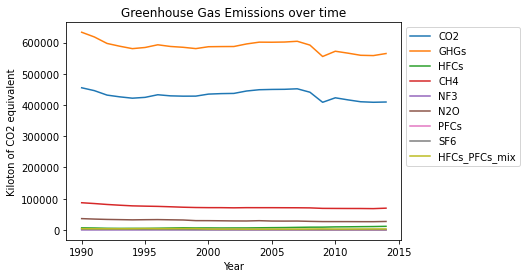

In [41]:
df.drop(["temp"], axis=1).plot()
plt.xlabel("Year")
plt.ylabel("Kiloton of CO2 equivalent")
plt.title("Greenhouse Gas Emissions over time")
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

The plot above has a line for each column in the dataframe (except temp, it has different units). This plot shows that the total greenhouse gas emissions (GHGs) are really dominated by carbon dioxide (CO2); it has by far the highest emissions by mass of the greenhouse gasses shown here. It's hard to see if there is a trend in the other greenhouse gas emissions with time because the y-axis here is only really suited for the scale of CO2 emissions. To fix this, I'll make a seperate plot for each of the greenhouse gasses. 

In [36]:
# TODO: combine HFCs and PFCs (also plot vs scatter??)

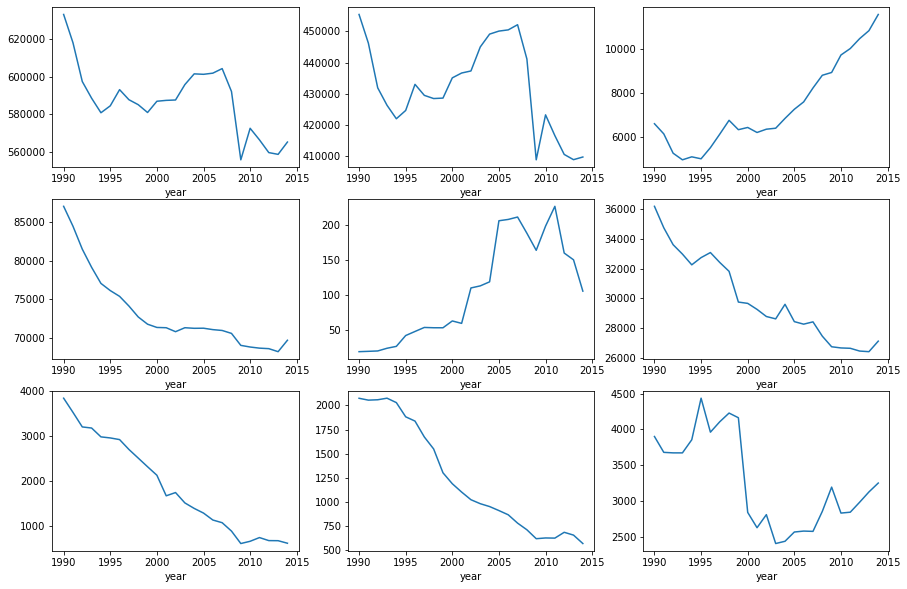

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
df["GHGs"].plot(ax=ax[0][0])
df["CO2"].plot(ax=ax[0][1])
df["HFCs"].plot(ax=ax[0][2])
df["CH4"].plot(ax=ax[1][0])
df["NF3"].plot(ax=ax[1][1])
df["N2O"].plot(ax=ax[1][2])
df["PFCs"].plot(ax=ax[2][0])
df["SF6"].plot(ax=ax[2][1])
df["HFCs_PFCs_mix"].plot(ax=ax[2][2]);

In [21]:
df_sum = df.drop(["GHGs_1", "GHGs_2", "temp"], axis=1).sum(axis=1)
df_sum

year
1990    595118.668544
1991    580891.161459
1992    561280.219831
1993    552386.945340
1994    545344.571340
1995    547888.946232
1996    555791.300451
1997    550714.706921
1998    548103.849956
1999    544311.536572
2000    548762.068174
2001    548884.811247
2002    548921.811107
2003    556341.944920
2004    561676.890093
2005    561973.113831
2006    562156.868242
2007    564330.201169
2008    552571.306745
2009    518114.428352
2010    532731.059490
2011    526316.528104
2012    520561.081360
2013    518909.476415
2014    522621.967884
dtype: float64

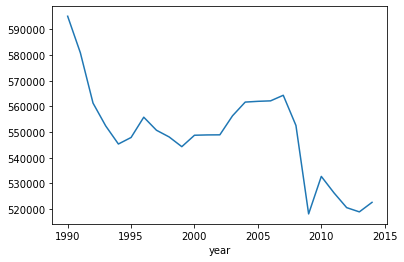

In [22]:
df_sum.plot();

# Extra